# Look at metric data based on Stackdriver groups

In this tutorial, we see how to look at the group structure in a project, and how to use groups to filter and aggregate metric data. For this tutorial to execute completely, you need to have:
* a [Stackdriver account](https://cloud.google.com/monitoring/accounts/)
* at least one [Stackdriver group](https://cloud.google.com/monitoring/api/ref_v3/rest/v3/projects.groups) in your account
* the above group must have at least one GCE instance in it

**Note**: It is recommended that you look at the [Getting Started](Getting started.ipynb) notebook first to familiarize yourself with the `Query` class and how `pandas` dataframes are used to represent time series data.

## Load the monitoring module and set the default project

If there is no default project set already, you must do so using 'set_datalab_project_id'. Note, the project you set here must be the [hosting project](https://cloud.google.com/monitoring/accounts/#account-project) for a Stackdriver account, otherwise you will see the following error while loading the groups in the next cell:

    `BadRequest: 400 The project 'my-project-id' is not a Stackdriver account project.`

In [1]:
# set_datalab_project_id('my-project-id')

## List the Stackdriver groups

Load the Stackdriver groups in the default project, and get the dataframe containing all the information.

In [2]:
from google.datalab.stackdriver import monitoring as gcm

groups_dataframe = gcm.Groups().as_dataframe()

# Sort the dataframe by the group name, and reset the index.
groups_dataframe = groups_dataframe.sort_values(by='Group name').reset_index(drop=True)
groups_dataframe.head(5)

,Group ID,Group name,Parent ID,Parent name,Is cluster,Filter
0,7072831048890135019,Aggregator,None,,True,"resource.metadata.tag:""aggregator"""
1,1200903745563401942,Alerting API,None,,True,"resource.metadata.tag:""alertingapi"""
2,6194133574331278967,Alerting Indexer,None,,True,"resource.metadata.tag:""alerting-indexer"""
3,1422901262723901359,Alerting Indexers,2622839688169354307,Gateway Cell,False,"resource.metadata.tag:""alerting-indexer"""
4,93201,Alerting-Cluster,None,,False,"resource.metadata.tag.""attached_to_cassandra_c..."


## Extract the first group

Now we initialize `first_group_id` from the list of Stackdriver groups. Please note:

* If you don't have any groups so far, please create one via the Stackdriver dashboard.
* Further, if the first group does not contain any GCE instances, please explicitly set `first_group_id` to the ID of a group that does have an instance.

In [3]:
import sys

if groups_dataframe.empty:
  sys.stderr.write('This project has no Stackdriver groups. The remaining notebook '
                   'will raise errors!')
else:
  first_group_id = groups_dataframe['Group ID'][0]
  print 'First group ID: %s' % first_group_id

First group ID: 7072831048890135019


## Load the CPU metric data for the instances a given group

Load the `CPU Utilization` for last 2 hours for the group with the ID `first_group_id`. The time series is further aggregated as follows:
* The data is `aligned` to 5 minute intervals using the `'ALIGN_MEAN'` method.
* The data per `zone` and `instance_name` pair is combined or `reduced` into a single time series. This is useful to combine the time series of instances that might be restarted / redeployed continuously.

In [4]:
# Initialize the query for the CPU Utilization metric over the last 2 hours.
query_group = gcm.Query('compute.googleapis.com/instance/cpu/utilization', hours=2)

# Filter the instances to the members of the first group.
query_group = query_group.select_group(first_group_id)

# Aggregate the time series.
query_group = query_group.align(gcm.Aligner.ALIGN_MEAN, minutes=5)
query_group = query_group.reduce(gcm.Reducer.REDUCE_MEAN, 'resource.zone', 'metric.instance_name')

# Create a dataframe with zone and instance name in the headers.
cpu_group_dataframe = query_group.as_dataframe(labels=['zone', 'instance_name'])
cpu_group_dataframe.tail(5)

zone                us-central1-a                             us-central1-b  \
instance_name       aggregator-20 aggregator-21 aggregator-23 aggregator-11   
2016-09-30 15:13:00      0.135458      0.101893      0.104206      0.118040   
2016-09-30 15:18:00      0.145385      0.386324      0.192046      0.301170   
2016-09-30 15:23:00      0.091374      0.071293      0.099174      0.089694   
2016-09-30 15:28:00      0.069921      0.070801      0.125611      0.115641   
2016-09-30 15:33:00      0.146956      0.203307      0.133793      0.125167   

zone                                                                       \
instance_name       aggregator-14 aggregator-17 aggregator-4 aggregator-8   
2016-09-30 15:13:00      0.141747      0.175101     0.137868     0.175497   
2016-09-30 15:18:00      0.186965      0.131623     0.139400     0.175684   
2016-09-30 15:23:00      0.112816      0.108992     0.165491     0.155889   
2016-09-30 15:28:00      0.107488      0.089655     0.097299     0.091715   
2016-09-30 15:33:00      0.220768      0.122868     0.147520     0.160335   

zone                us-central1-c               us-central1-f                \
instance_name       aggregator-19 aggregator-22  aggregator-1 aggregator-12   
2016-09-30 15:13:00      0.108193      0.141040      0.178988      0.120532   
2016-09-30 15:18:00      0.128571      0.354794      0.174412      0.152978   
2016-09-30 15:23:00      0.082850      0.107264      0.112423      0.128556   
2016-09-30 15:28:00      0.079266      0.106138      0.092517      0.082710   
2016-09-30 15:33:00      0.128537      0.164543      0.211647      0.178172   

zone                                                                       
instance_name       aggregator-15 aggregator-18 aggregator-2 aggregator-9  
2016-09-30 15:13:00      0.118997      0.147518     0.139033     0.132069  
2016-09-30 15:18:00      0.180334      0.186613     0.148138     0.146208  
2016-09-30 15:23:00      0.078999      0.112612     0.113608     0.081545  
2016-09-30 15:28:00      0.089708      0.106778     0.102915     0.099088  
2016-09-30 15:33:00      0.159379      0.182900     0.135458     0.112765

### Plot the the mean of the CPU Utilization per zone

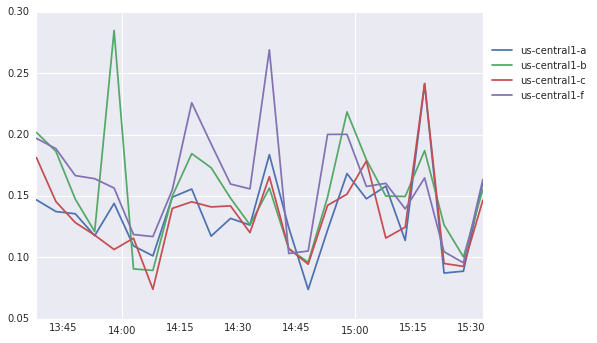

In [5]:
cpu_group_dataframe_per_zone = cpu_group_dataframe.groupby(level=0, axis=1).mean()
_ = cpu_group_dataframe_per_zone.plot().legend(loc='center left', bbox_to_anchor=(1.0, 0.8))

### Plot the CPU Utilization of instances

Now, we plot the chart at the instance level. However, instances in each zone are displayed in a separate chart.

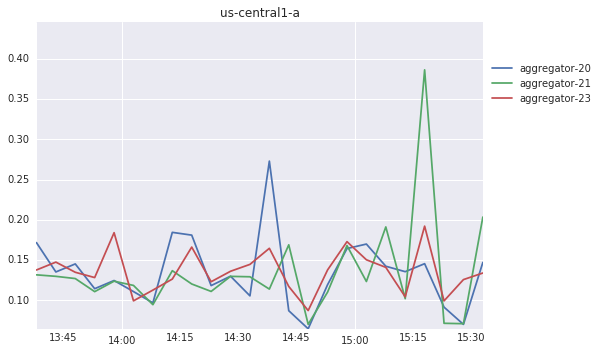

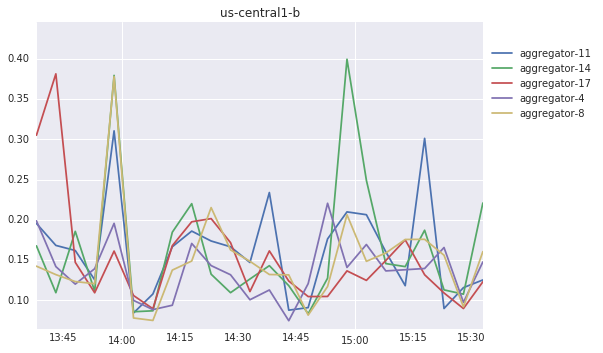

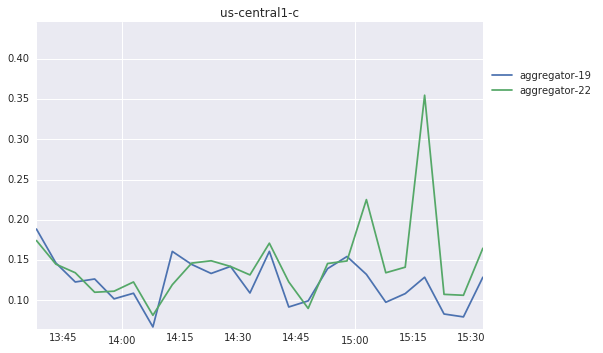

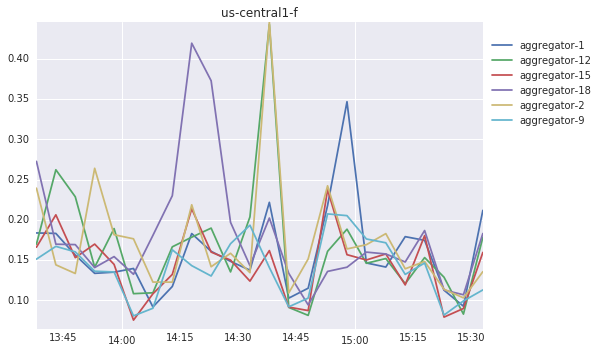

In [6]:
# Find all unique zones and sort them.
all_zones = sorted(set(cpu_group_dataframe.columns.get_level_values('zone')))

# Find the global min and max so we can set the same range for all y-axes.
min_cpu = cpu_group_dataframe.min().min()
max_cpu = cpu_group_dataframe.max().max()

for zone in all_zones:
  zone_plot = cpu_group_dataframe[zone].plot(title=zone, ylim=(min_cpu, max_cpu))
  zone_plot.legend(loc='center left', bbox_to_anchor=(1.0, 0.8))